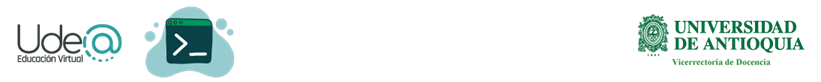

---
# Laboratorio Estimación de Densidad
## Modelos de mezclas de Gaussianas

**Laboratorio Tratamiento de Señales III**

*   Mateo Muñoz Arroyave
CC 1036676919

*   David Esteban Londoño Patiño
CC 1020465536

**Facultad de Ingeniería**

**Universidad de Antioquia**

**Autor: Pablo Alejandro Alvarado Duran**

**2023-II**

---
## Introducción

Anteriormente hemos abordado temas fundamentales del aprendizaje de máquina, específicamente regresión, y reducción de dimensionalidad (PCA). Otra área importante del aprendizaje de máquina es la _estimación de densidad_:

- Las observaciones que conforman una base de datos son interpretadas como realizaciones de una distribución de probabilidad.

- El propósito de la _estimación de densidad_ es encontrar una aproximación de dicha función de probabilidad.

En la práctica, las bases de datos que utilizamos presentan características más complejas que las que pueden ser descritas por una sola distribución de probabilidad paramétrica. Esto motiva la formulación y uso de _modelos de mezclas_.

---
## Modelo de mezcla de Gaussianas

Los _modelos de mezclas_ describen una función de probabilidad como una suma ponderada de $K$ funciones de probabilidad base (por ejemplo Gaussiana, Bernoulli, Gamma).

Nos enfocaremos en modelos de mezclas de Gaussianas (MMG), donde las funciones de probabilidad base son _normales_ (Gaussiana = Normal).


> **Pregunta:** ¿Por qué se considera que los modelos de mezcla son más expresivos en comparación con las funciones de probabilidad base?


**Respuesta:**

_Por favor escriba su respuesta aquí._


Los modelos de mezclas de Gaussianas están definidos como

$$
p(\textbf x_n| \boldsymbol \theta) =
\sum_{k=1}^K \pi_k
\mathcal{N}
(\textbf x_n | \boldsymbol \mu_k, \boldsymbol \Sigma_k),
$$
donde
$$
0 \leq \pi_k \leq 1,
\quad
\sum_{k=1}^K \pi_k = 1,
$$

$\pi_k$ representa los _pesos de mezcla_, y los parámetros $\boldsymbol \theta$ corresponden a

$$
\boldsymbol{\theta} =
\left\{
\boldsymbol{\mu}_k,
\boldsymbol{\Sigma}_k,
\pi_k
:
k = 1, \dots, K
\right\}.
$$

---
## Función objetivo

> ¿Cómo entrenamos un MMG para que se ajuste a una base de datos $
\mathcal X = \{\textbf x_1, \dots, \textbf x_N \}$?

> ¿Cómo aproximamos la distribución de probabilidad $p(\textbf{x})$ de la cual se generaron los datos observados $\mathcal X$?

Partiendo de nuestra experiencia previa, podríamos proponer cómo función objetivo maximizar la verosimilitud de los datos.

Observemos qué sucede si proponemos el logaritmo de la verosimilitud de los datos como función objetivo

$$
\log p(\mathcal X | \boldsymbol \theta) =
\log\prod_{n=1}^{N}  p(\textbf x_n | \boldsymbol \theta) =
\sum_{n=1}^{N} \log p(\textbf x_n | \boldsymbol \theta) =
\sum_{n=1}^{N}
\log \sum_{k=1}^{K}
\pi_k
\mathcal{N}
(\textbf x_n | \boldsymbol \mu_k, \boldsymbol \Sigma_k)
$$

- No podemos obtener una solución en forma cerrada para los parámetros que maximizan esta función objetivo.

- Este problema puede solucionarse a través de un algoritmo iterativo llamado _Maximización de la Esperanza_.

---
## Inferencia

### Responsabilidades

Antes de definir el algoritmo de inferencia vamos a introducir el concepto de _responsabilidad_. Esta cantidad está definida como

$$ r_{nk} =
\frac
{
  \pi_k \mathcal{N}(\textbf x_n | \boldsymbol \mu_k, \boldsymbol \Sigma_k)
}
{
\sum_{j=1}^{K}
\pi_j
\mathcal{N}
(\textbf x_n |
\boldsymbol \mu_j, \boldsymbol\Sigma_j)
}
$$

La responsabilidad $r_{nk}$ representa la probabilidad de que el $n$-ésimo dato haya sido muestreado de la $k$-ésima distribución de la mezcla.




A continuación se muestran las expresiones para actualizar los parámetros del MMG:


\begin{align*}
\boldsymbol\mu_k^\text{new} &=
\frac{1}{N_k}\sum_{n = 1}^Nr_{nk}\textbf x_n\,,
\\
\boldsymbol\Sigma_k^\text{new}&= \frac{1}{N_k}\sum_{n=1}^Nr_{nk}(\textbf x_n-\boldsymbol\mu_k)(\textbf x_n-\boldsymbol\mu_k)^\top\,,
\\
\pi_k^\text{new} &= \frac{N_k}{N},
\\
N_k &= \sum_{n=1}^N r_{nk}.
\end{align*}

Donde $N_k$ es la responsabilidad total de la $k$-ésima componente para toda la base de datos $\mathcal X$.


---
## Algoritmo maximización de la esperanza (EM)

En los MMGs no es posible encontrar una expresión cerrada para los parámetros $\boldsymbol{\theta}$, debido a que estos dependen de la responsabilidades $r_{nk}$.

Sin embargo, es posible estimar $\boldsymbol{\theta}$ utilizando un algoritmo iterativo llamado _maximización de la esperanza (EM)_:

>**Algoritmo EM:**
1. Inicializar los parámetros $\boldsymbol{\theta}$.
2. **Paso E:** evaluar las responsabilidades $r_{nk}$, es decir, la probabilidad posterior de que el $n$-ésimo dato pertenezca a la $k$-ésima componente de mezcla.
3. **Paso M:** utilizar las responsabilidades $r_{nk}$ actualizadas para re-estimar los parámetros $\boldsymbol{\theta}$.
4. Repetir los pasos 2 y 3 hasta satisfacer un determinado criterio de convergencia.

Cada iteración del algoritmo EM incrementa el logaritmo de la verosimilitud (función objetivo).

---
## Ejemplo: mezcla de Gaussianas en 1D

Ajustaremos una mezcla de Gaussianas con $K=3$, sobre datos observados en un espacio de dimensión 1, es decir $\textbf{x}_n \in \mathbb{R}$.  

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import scipy.linalg as la
import matplotlib.cm as cm
from matplotlib import rc
import time
from scipy.stats import norm

np.random.seed(42)

In [ ]:
def mmg(k, pi, mu, var):
  pK = []
  for i in range(k):
    pK.append(pi[i]*norm.pdf(x, mu[i], np.sqrt(var[i])))
  return pK

In [ ]:
def plot_results(x, X, pK):
  plt.ylim(-0.025, 0.36)
  for k in range(3):
    plt.plot(x, pK[k],'-', lw=3, label='Componente '+str(k+1))
  plt.plot(x, sum(pK), 'k-', label='Mezcla')
  plt.plot(X, 0*X, 'ok', label='datos')
  plt.legend()

In [ ]:
X = np.asarray([-3., -2.5, -1.0, 0.0, 2.0, 4.0, 5.0]) # datos
x = np.linspace(-10, 15, 1000) # variable entrada para evaluar Gaussianas
k = 3 # parámetros MMG
pi = [1.0/3.0, 1.0/3.0, 1.0/3.0]
mu = [-4.0, 0.0, 8.0]
var = [1.0, 0.2, 3.0]

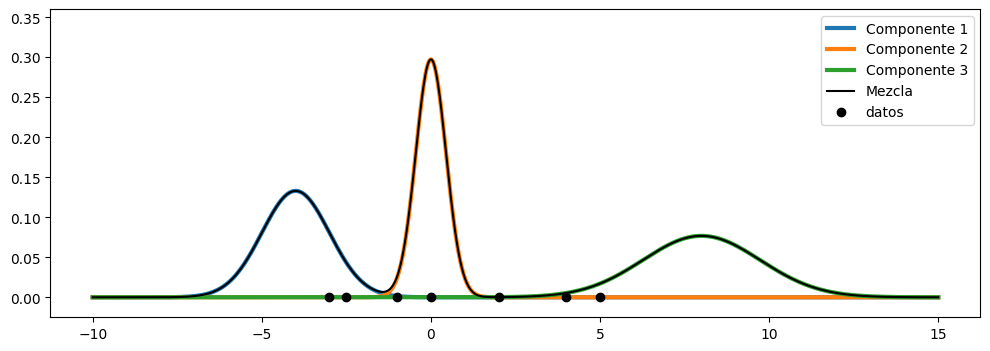

In [ ]:
pK0 = mmg(k, pi, mu, var)

plt.figure(figsize=(12,4))
plot_results(x, X, pK0)

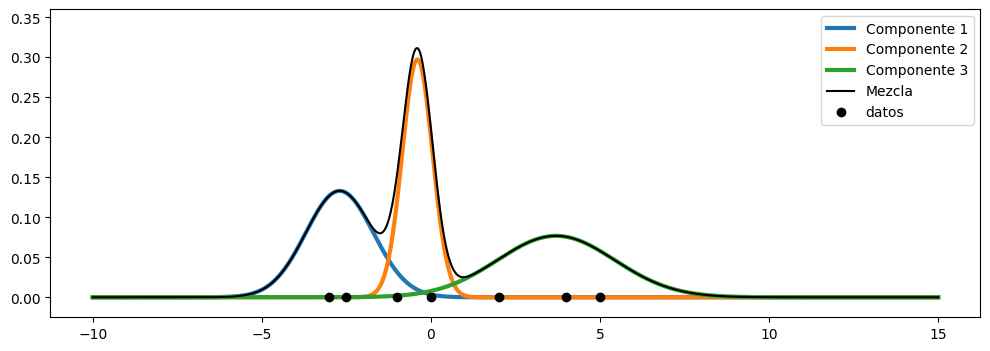

In [ ]:
mu = [-2.7, -0.4, 3.7]
pK_mu = mmg(k, pi, mu, var)

plt.figure(figsize=(12,4))
plot_results(x, X, pK_mu)

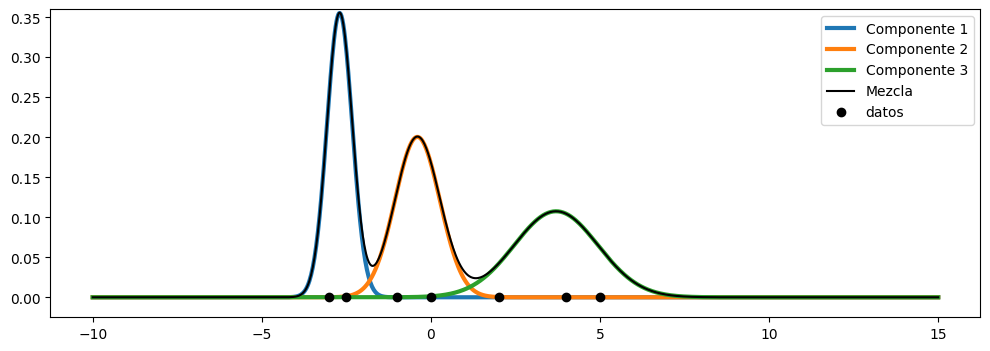

In [ ]:
var = [0.14, 0.44, 1.53]
pK_var = mmg(k, pi, mu, var)

plt.figure(figsize=(12,4))
plot_results(x, X, pK_var)

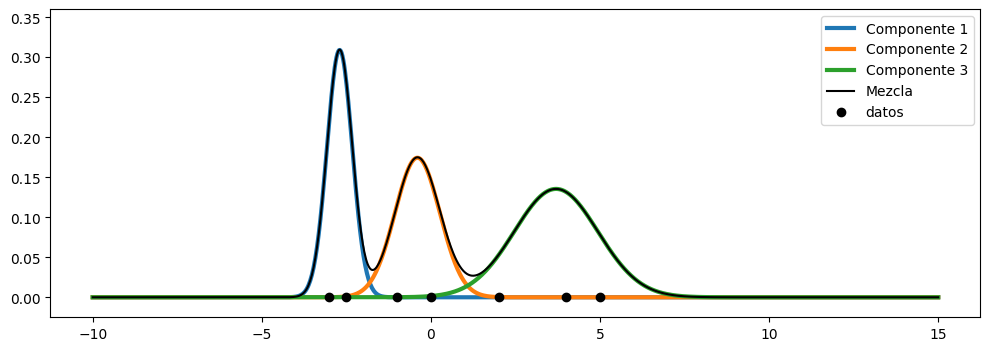

In [ ]:
pi = [0.29, 0.29, 0.42]
pK_pi = mmg(k, pi, mu, var)

plt.figure(figsize=(12,4))
plot_results(x, X, pK_pi)

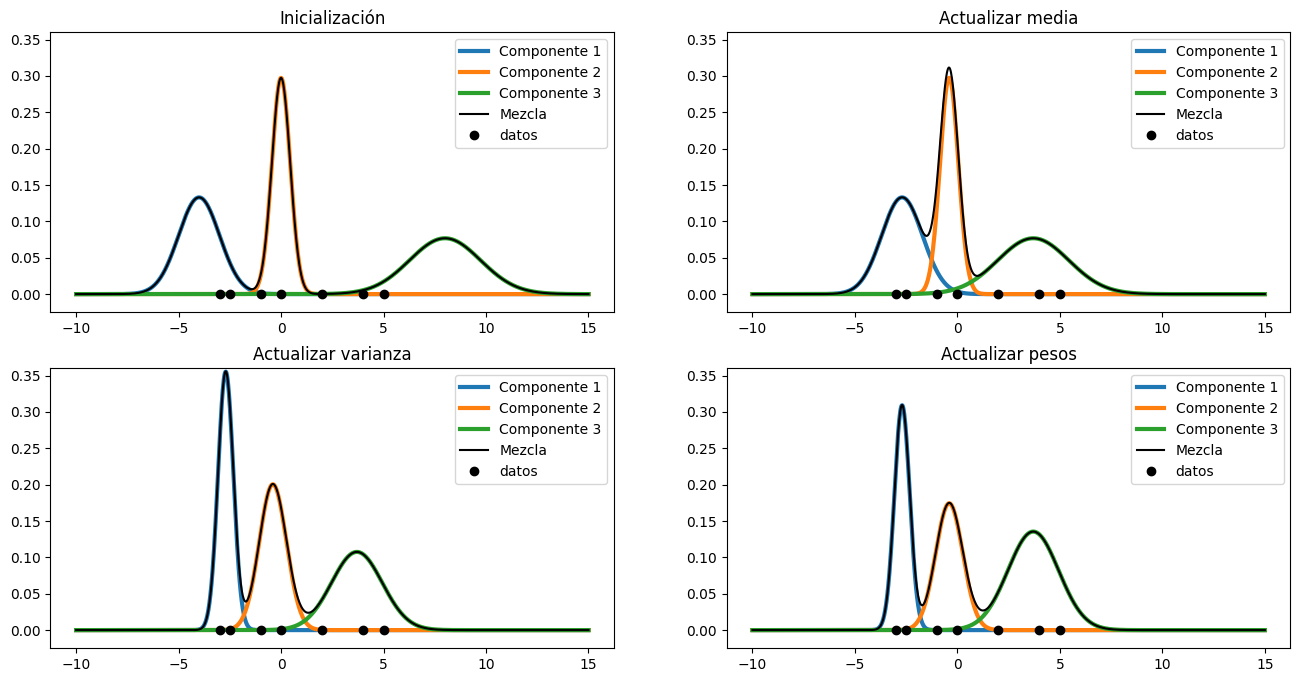

In [ ]:
pK_all = [pK0, pK_mu, pK_var, pK_pi]
t_all = ["Inicialización",
         "Actualizar media",
         "Actualizar varianza",
         "Actualizar pesos"]
plt.figure(figsize=(16,8))
for i in range(4):
  plt.subplot(2,2,1+i)
  plot_results(x, X, pK_all[i])
  plt.title(t_all[i])

---
# **Trabajo de laboratorio**

> **Nota:**
 - Utilizar la bibliografía sugerida para encontrar código de Python relacionado con el laboratorio.

1. En la primera parte del trabajo de laboratorio vamos a extender a dos dimensiones el ejemplo visto anteriormente. En este caso, aproximaremos la distribución de datos definidos en un espacio de dos dimensiones ($\textbf{x}_n \in \mathbb{R}^2$). Asumiendo que el número de Gaussianas es $K=3$, realizar el siguiente procedimiento:

In [ ]:
def mmg(k, pi, mu, var):
  pK = []
  for i in range(k):
    pK.append(pi[i]*norm.pdf(x, mu[i], np.sqrt(var[i])))
  return pK


 * *1.1.* Genere 200 muestras de cada una de las siguientes distribuciones y luego concatene todas las observaciones en una sola base de datos $\mathcal X$,
 $$
 p_k(\textbf x) =
 \mathcal N
 (\boldsymbol \mu_k, \boldsymbol \Sigma_k),
 $$
  donde para $k=1$
 $$
 \boldsymbol \mu_1 =
\begin{bmatrix}
1.2\\ 0.4
\end{bmatrix},
\quad
\boldsymbol \Sigma_1 =
\begin{bmatrix}
 0.8 & -0.4 \\
 -0.4 & 1.0
\end{bmatrix},
 $$
 para $k=2$
 $$
 \boldsymbol \mu_2 =
\begin{bmatrix}
-4.4\\ 1
\end{bmatrix},
\quad
\boldsymbol \Sigma_2 =
\begin{bmatrix}
 1.2 & -0.8 \\
 -0.8 & 1.0
\end{bmatrix},
 $$
 y para $k=3$
 $$
 \boldsymbol \mu_3 =
\begin{bmatrix}
4.1\\ -0.3
\end{bmatrix},
\quad
\boldsymbol \Sigma_3 =
\begin{bmatrix}
 1.2 & 0.6 \\
 0.6 & 3.0
\end{bmatrix}.
 $$


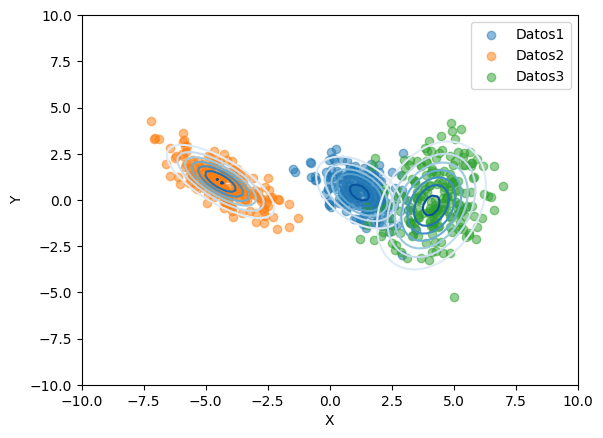

In [ ]:
k = 3 # parámetros MMG

means = [[1.2,0.4],[-4.4,1.],[4.1,-0.3]]
covs =[[[0.8, -0.4],[-0.4,1.]],[[1.2, -0.8],[-0.8,1.]],[[1.2, 0.6],[0.6,3.]]]
pi = [1.0/3.0, 1.0/3.0, 1.0/3.0]

# Definimos los rangos para ambas variables
data_1 = np.random.multivariate_normal(means[0], covs[0], 200)
data_2 = np.random.multivariate_normal(means[1], covs[1], 200)
data_3 = np.random.multivariate_normal(means[2], covs[2], 200)
data = np.concatenate((data_1,data_2,data_3),axis = 0)

# Creamos la malla de puntos bidimensional utilizando meshgrid
X, Y = np.meshgrid(np.linspace(-10,10,100), np.linspace(-10,10,100))
pos = np.dstack((X, Y))

pdf_values = mmg_multi(k,pi,means,covs,pos)

plt.scatter(data_1[:, 0], data_1[:, 1], alpha=0.5, label='Datos1')
plt.scatter(data_2[:, 0], data_2[:, 1], alpha=0.5, label='Datos2')
plt.scatter(data_3[:, 0], data_3[:, 1], alpha=0.5, label='Datos3')
plt.contour(X, Y, pdf_values[0], cmap='Blues')
plt.contour(X, Y, pdf_values[1], cmap='Blues')
plt.contour(X, Y, pdf_values[2], cmap='Blues')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()


 * *1.2.* Entrene diferentes MMGs, para $K= 1,2,3,4$ y grafique: la inicialización del MMG, un estado intermedio, y su forma final, de manera que se evidencie la evolución y convergencia de los parámetros del modelo. Inicialize los parámetros $\boldsymbol \theta$ de manera que cada distribución tenga un vector media igual a cero $\boldsymbol \mu_k = \boldsymbol 0$, y una matriz de covarianza identidad $\boldsymbol \Sigma_k = \textbf I$. Distribuya los pesos $\pi_k$ de manera equitativa entre todas las $K$ componentes, es decir $\pi_k = \frac{1}{K}$.

* *1.3.* Además, para cada iteración calcule el logaritmo de la verosimilitud y en una sola gráfica muestre estos valores (eje y) para cada iteración (eje x).

In [ ]:
def mean_cov_weight(K):
  means = np.zeros((K,2))
  covs = np.zeros((K,2,2))
  for k in range(K):
      covs[k] = np.eye(2)
      means[k] = np.random.normal(size=(2,))

  weights = np.ones((K,1))/K
  return means,covs,weights

def em_loop(data,max_iter,K):

  means,covs,weights = mean_cov_weight(K)
  NLL = []
  N = data.shape[0]
  r = np.zeros((K,N)) # will store the responsibilities

  for em_iter in range(max_iter):

    if em_iter == 0 or em_iter == int((max_iter-1)/2) or em_iter == max_iter-1:
      plt.figure()
      plt.plot(data[:,0], data[:,1], 'ko', alpha=0.3)

      for k in range(K):
          rv = multivariate_normal(means[k,:], covs[k])
          plt.contour(X, Y, rv.pdf(pos), alpha = 1.0, zorder=10)

      plt.xlabel("$x_1$")
      plt.ylabel("$x_2$")
      plt.text(x=3.5, y=8, s="EM iteration "+str(em_iter+1))

    # E-step: update responsibilities
    for k in range(K):
        r[k] = weights[k]*multivariate_normal.pdf(mean=means[k,:], cov=covs[k,:,:], x=data)
    r = r/np.sum(r, axis=0)

    # M-step
    N_k = np.sum(r, axis=1)

    for k in range(K):
        # update means
        means[k] = np.sum(r[k]*data.T, axis=1)/N_k[k]
        # update covariances
        diff = data.T - means[k:k+1].T
        _tmp = np.sqrt(r[k:k+1])*diff
        covs[k] = np.inner(_tmp, _tmp)/N_k[k]

    # weights
    weights = N_k/N

    # log-likelihood
    gmm_nll = 0
    for k in range(K):
        gmm_nll += weights[k]*multivariate_normal.pdf(mean=means[k,:].ravel(),cov=covs[k,:,:], x=data)
    NLL += [-np.sum(np.log(gmm_nll))]

    if em_iter > 0 and la.norm(NLL[em_iter]-NLL[em_iter-1]) < 1e-6:
        print("Converged after iteration ", em_iter+1)
        break

  # plot final the mixture model
  plt.figure(figsize=(8,8))
  gmm = 0
  for k in range(K):
      mix_comp = multivariate_normal(means[k,:].ravel(), covs[k,:,:])
      gmm += weights[k]*mix_comp.pdf(pos)

  plt.plot(data[:,0], data[:,1], 'ko', alpha=0.3)
  plt.contour(X, Y, gmm,  alpha = 1.0, zorder=10)
  plt.title('FINAL MIXTURE MODEL', fontsize=14, fontweight='bold', color='blue')
  plt.show()

  return NLL

def print_nll(nll):
  iteration = np.linspace(0,len(nll),len(nll))
  plt.plot(iteration,nll)
  plt.xlabel('Iteración')
  plt.ylabel('log_vero')

Converged after iteration  2


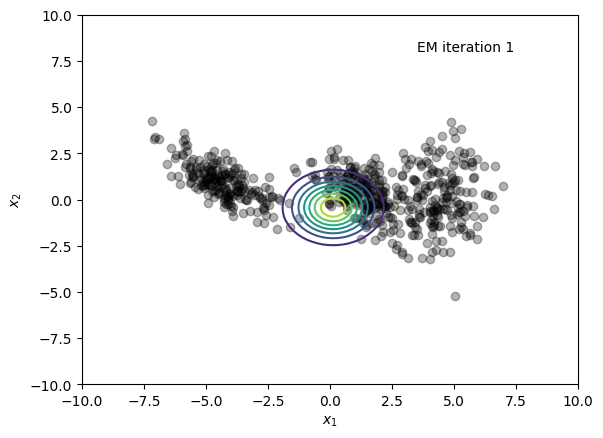

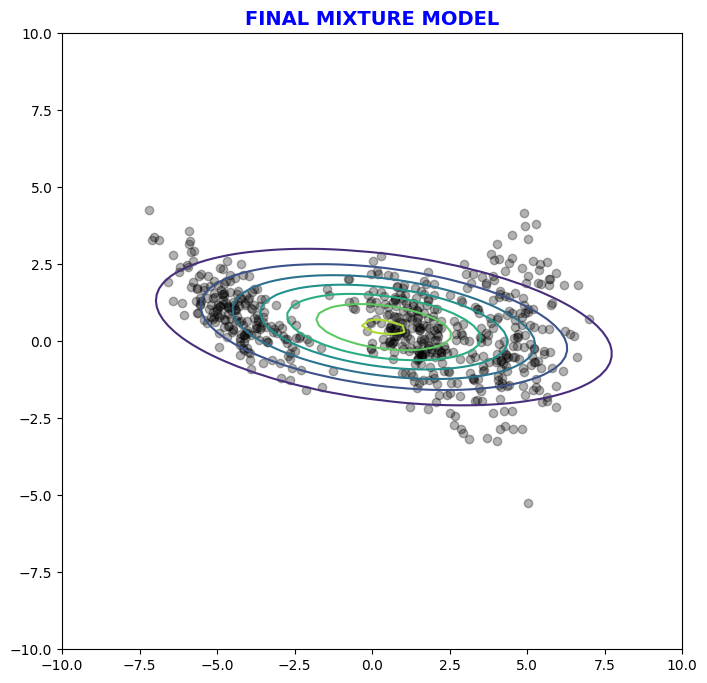

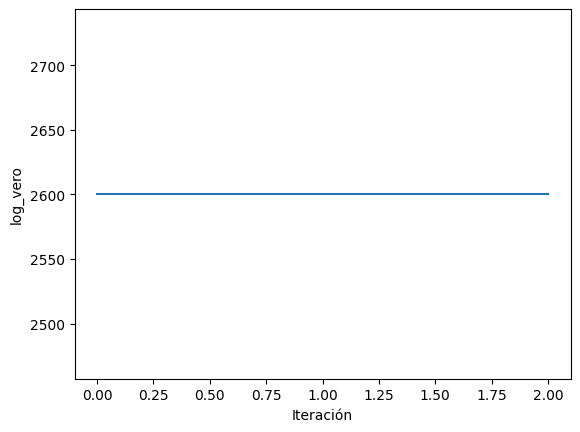

In [ ]:
nll = em_loop(data,100,1)
print_nll(nll)

Converged after iteration  39


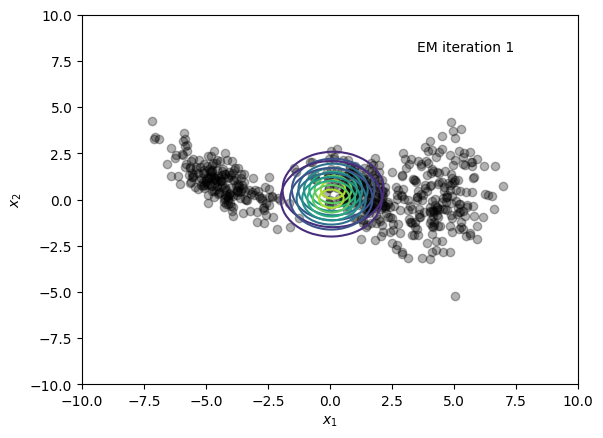

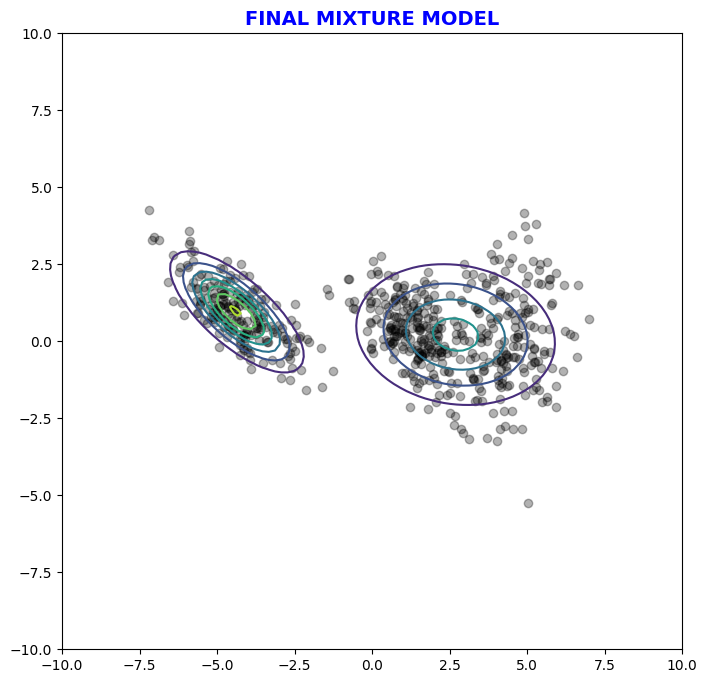

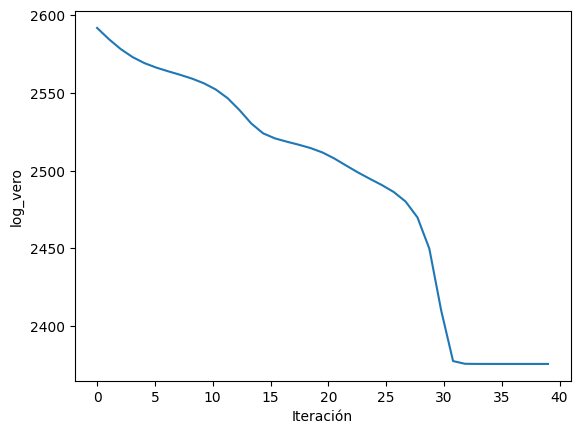

In [ ]:
nll = em_loop(data,100,2)
print_nll(nll)

Converged after iteration  71


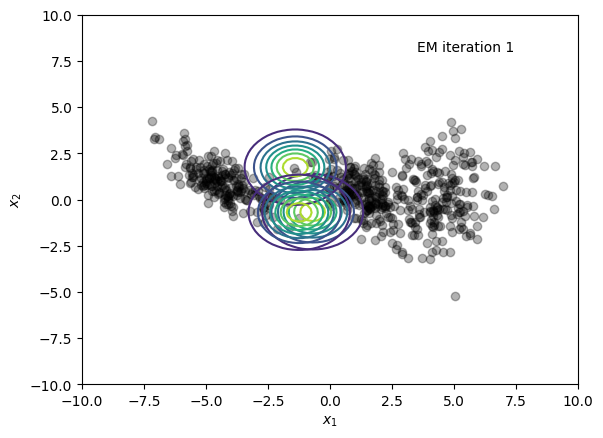

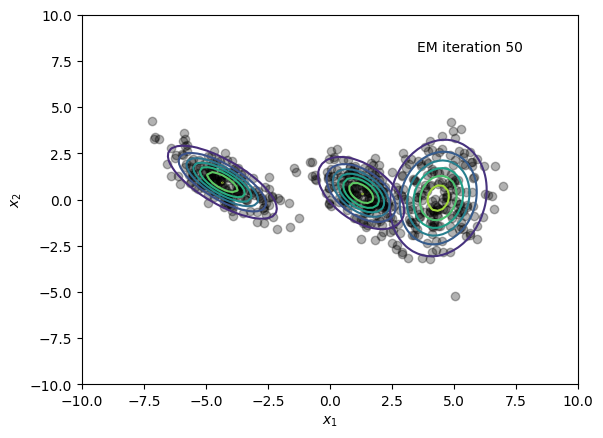

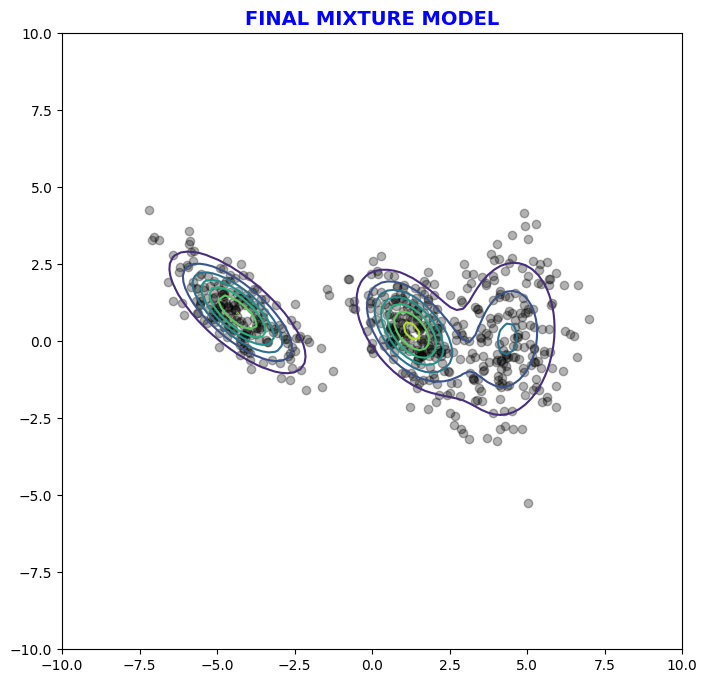

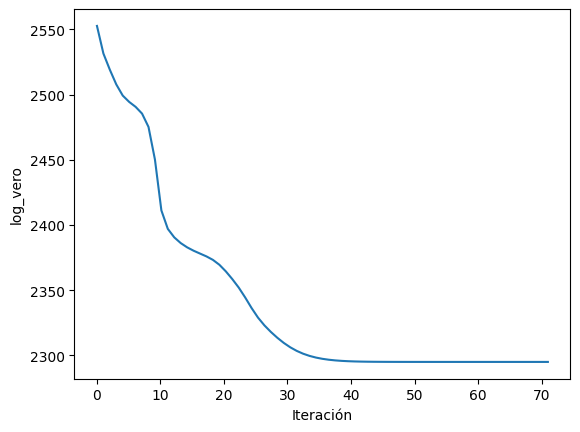

In [ ]:
nll = em_loop(data,100,3)
print_nll(nll)

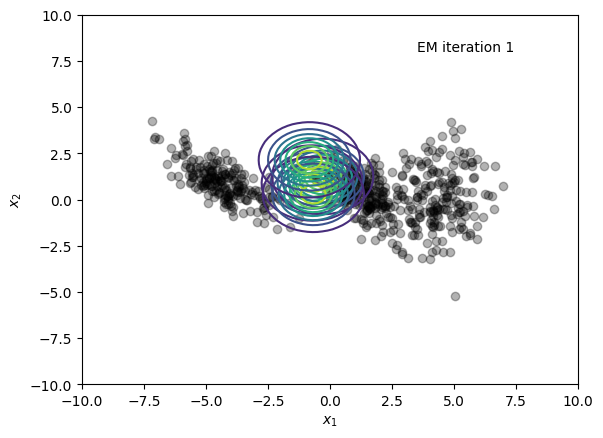

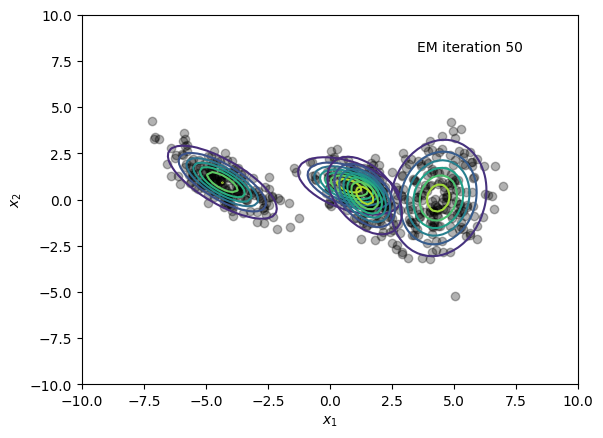

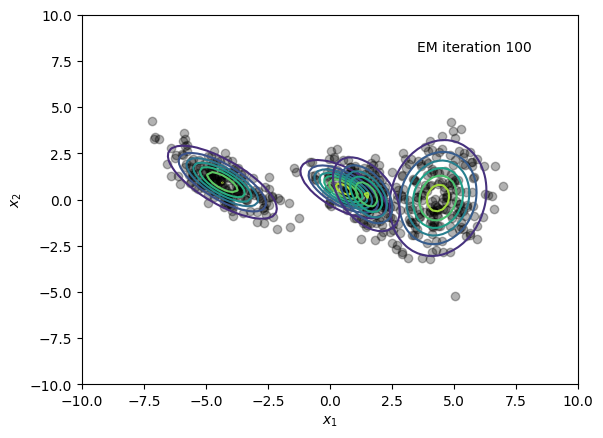

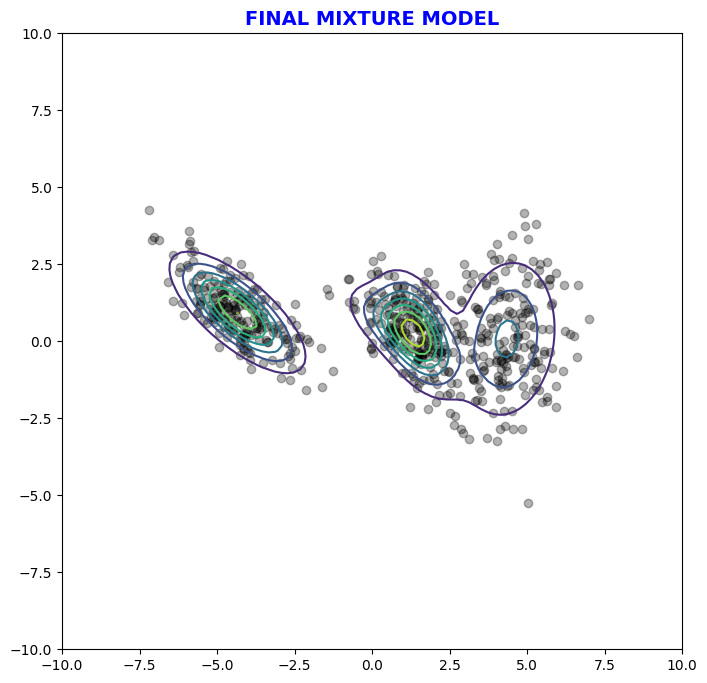

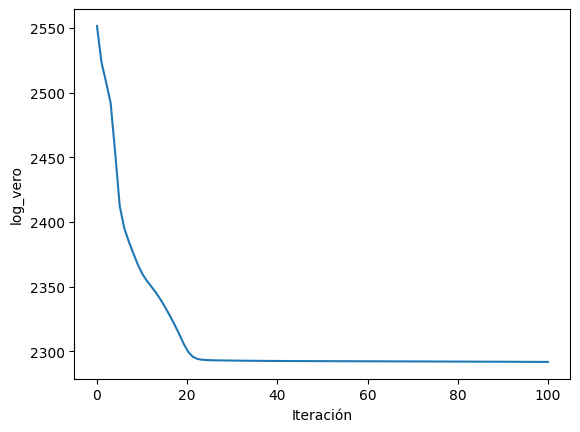

In [ ]:
nll = em_loop(data,100,4)
print_nll(nll)

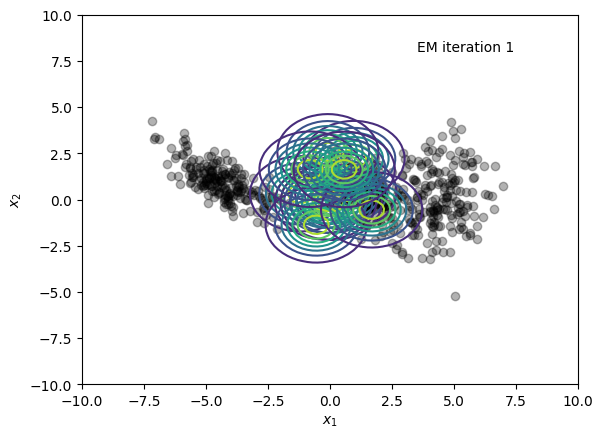

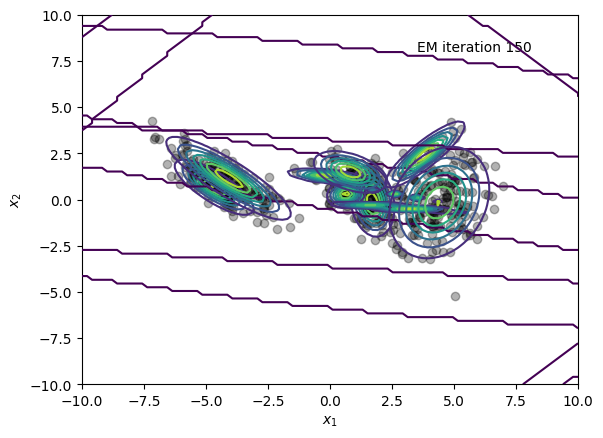

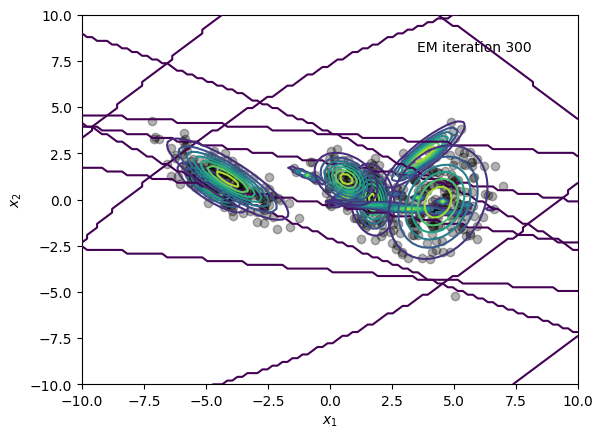

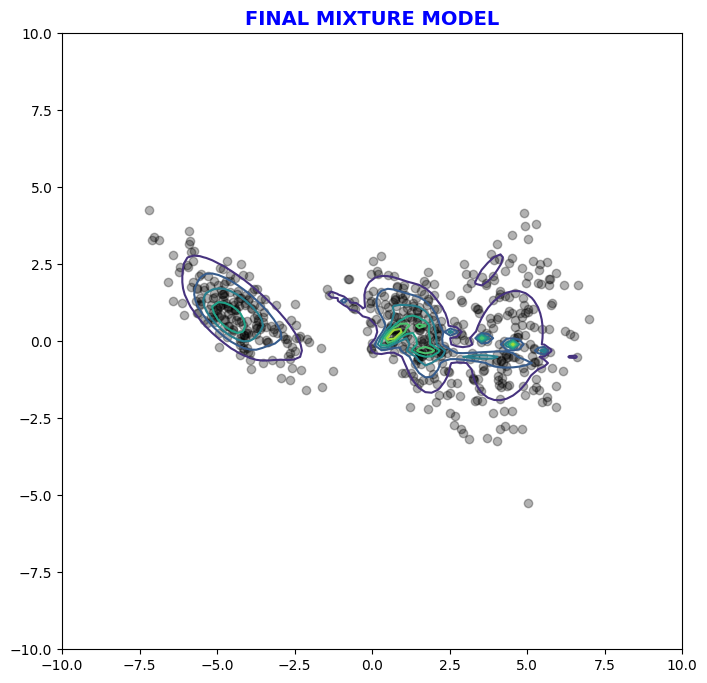

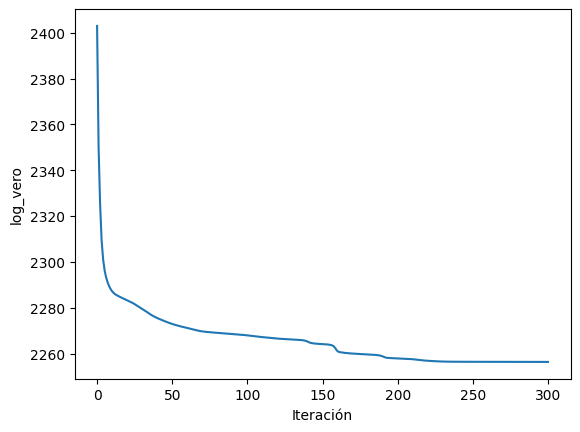

In [ ]:
nll = em_loop(data,300,10)
print_nll(nll)

> **Preguntas punto 1:**
- *1.1.* De acuerdo a los resultados obtenidos, cómo afecta el número de componentes $K$ a la distribución aprendida a partir de los datos?
- *1.2.* Describa la evolución del MMG desde su inicialización hasta su convergencia, durante las iteraciones del algoritmo de inferencia (EM) ¿Qué puede concluir de estos resultados?

**Respuestas punto 1:**

*1.1.* Cuando el número de componentes K es menor que el número de clasificaciones reales, el proceso de entrenamiento se vuelve más "general", lo que significa que el resultado del entrenamiento abarca zonas más amplias y puede combinar conjuntos de diferentes clasificaciones. En este escenario, la capacidad de separar eficazmente las diferentes clasificaciones disminuye.

Al tener el número de componentes igual al número de clasificaciones, el comportamiento del modelo es altamente efectivo. En esta configuración, el modelo entrenado logra separar de manera más precisa y clara las diferentes clasificaciones, lo que resulta en un rendimiento óptimo.

Sin embargo, cuando el número de componentes es mayor que la cantidad de clasificaciones en los datos, se dificulta la diferenciación entre conjuntos, e incluso puede dar lugar a la aparición de nuevos conjuntos de datos dentro de una misma clasificación. A pesar de esta disminución en la capacidad de separación, es importante destacar que el logaritmo de la verosimilitud mejora, mostrando un valor menor en comparación con los casos anteriores.


*1.2.* A medida que el algoritmo evolucionaba, se recalculaban los pesos, las medias y las covarianzas de cada una de las Gaussianas con el objetivo de acercarlas más a cada uno de los conjuntos de datos. En términos generales, este proceso conducía a una disminución del logaritmo de la verosimilitud, lo que indicaba una mejor aproximación del modelo a los datos observados.

Es importante resaltar que durante este proceso de entrenamiento, se utilizaron inicializaciones aleatorias para las medias y se empleó la matriz identidad para las covarianzas. Esta elección se debió a que, cuando se inicializaban las medias en cero, todas las Gaussianas tenían la misma media y la misma matriz de covarianza. Como resultado, todas las Gaussianas se superponían, lo que equivalía a tener una sola componente Gaussiana. La introducción de inicializaciones aleatorias permitió que las Gaussianas se diferenciaran y se ajustaran de manera más efectiva a los datos.





2. Utilice una base de datos de clasificación, cuyo vector de entrada tenga dimensión mayor a uno, por ejemplo utilizar la base de datos estandar de vinos (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html), o las características extraídas en el mini proyecto 1, para realizar el siguiente procedimiento:

  2.1. Utilizar análisis de componentes principales (PCA) para reducir a dos ($\textbf z_n \in \mathbb{R}^2$) la dimensión del vector de características de entrada ($\textbf x_n \in \mathbb{R}^D$).


In [ ]:
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import load_wine
wine = load_wine()
vinos_data = wine.data
scaler = StandardScaler()
scaler.fit(vinos_data)
vinos_data= scaler.transform(vinos_data)

In [ ]:
# Creamos el modelo PCA
def PcaComponents(X, n):
  pca_Components = PCA(n_components=n)
  XPCAcomponents = pca_Components.fit_transform(X)
  print("transformed shape:", XPCAcomponents.shape)
  return XPCAcomponents

transformed shape: (178, 2)
transformed shape: (178, 2)


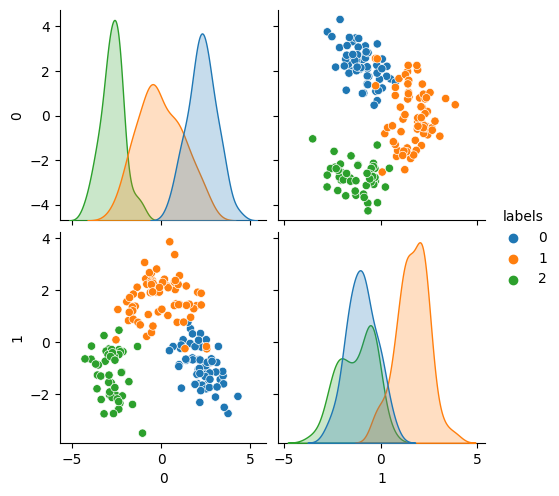

In [ ]:
dataFramePCA= pd.DataFrame( PcaComponents(vinos_data,n=2))
vinos = PcaComponents(vinos_data,n=2)
dataFramePCA['labels'] = wine.target
sns.pairplot(dataFramePCA, hue='labels', palette= 'tab10')

*  2.2. Entrenar un modelo de mezclas de Gaussianas para _K_ igual a el número de clases o etiquetas en su base de datos. Graficar el estado del MMG en pasos intermedios, así como su inicialización y forma final, de manera que se observe la evolución y convergencia de la mezcla de Gaussianas.

* 2.3. Repetir el paso 2.2 utilizando diferentes valores de inicialización para los parámetros $\boldsymbol \theta$ del modelo de mezclas.

Converged after iteration  2


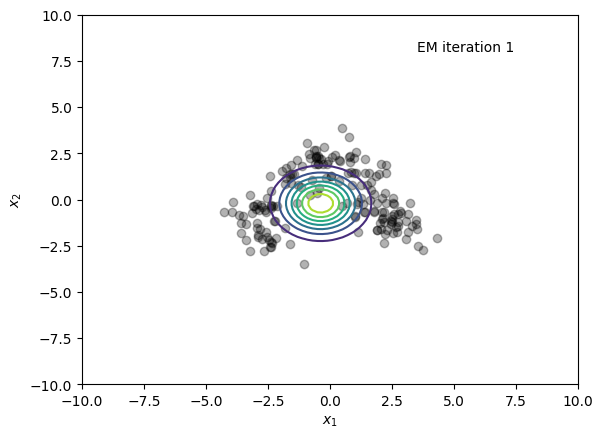

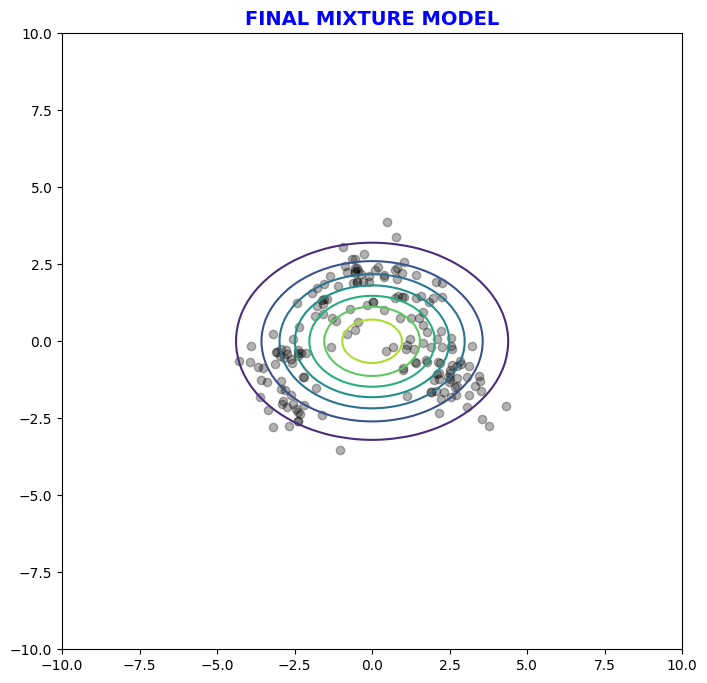

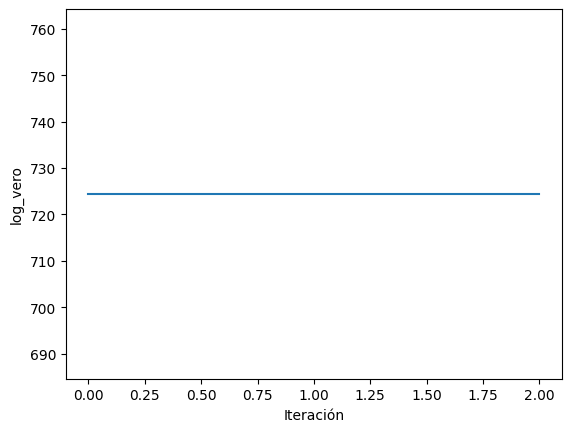

In [ ]:
nll = em_loop(vinos,100,1)
print_nll(nll)

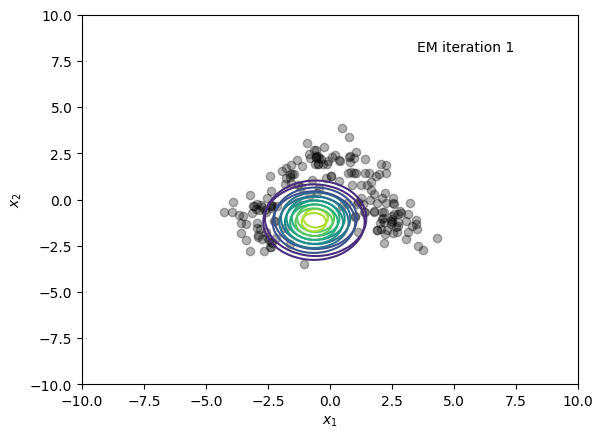

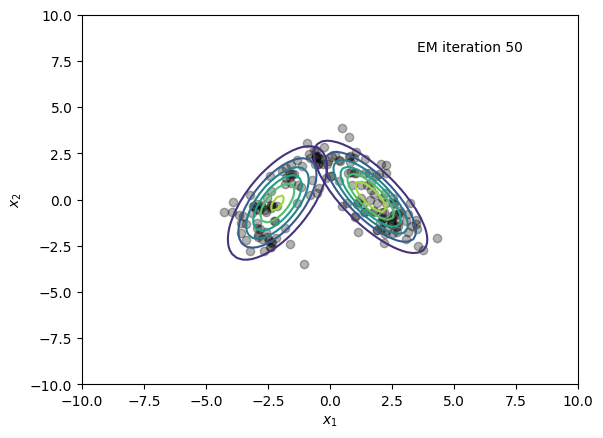

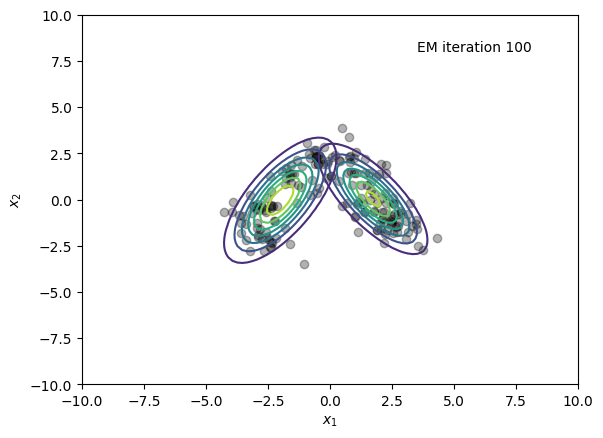

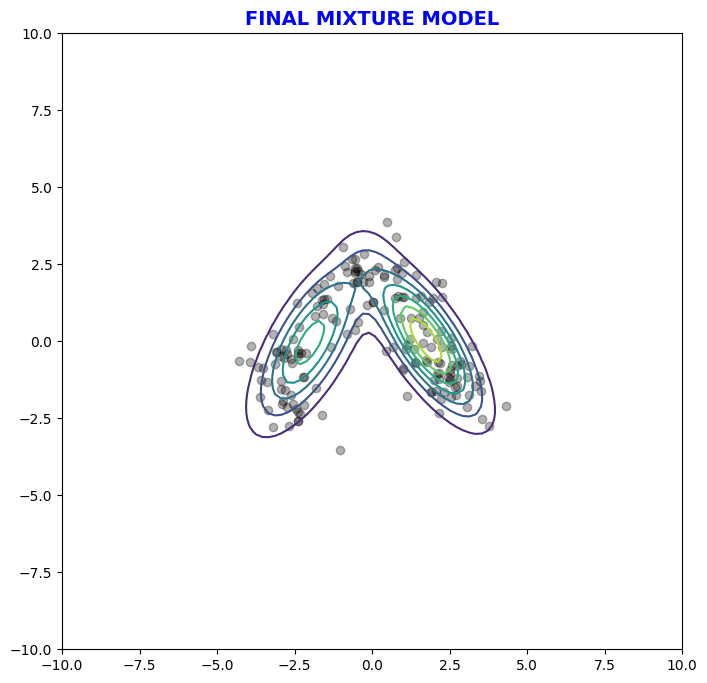

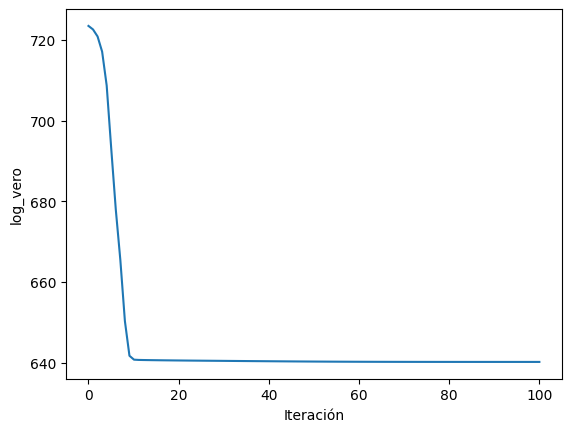

In [ ]:
nll = em_loop(vinos,100,2)
print_nll(nll)

Converged after iteration  38


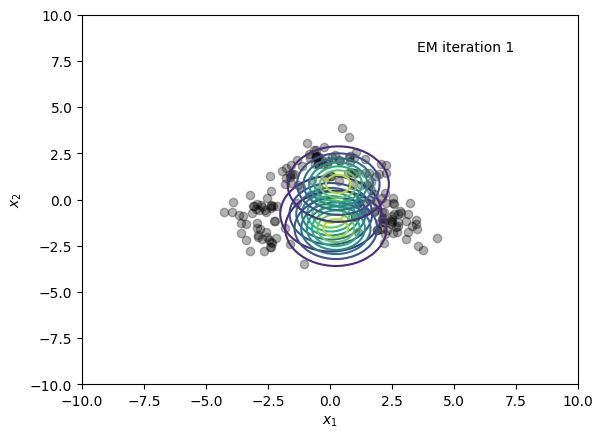

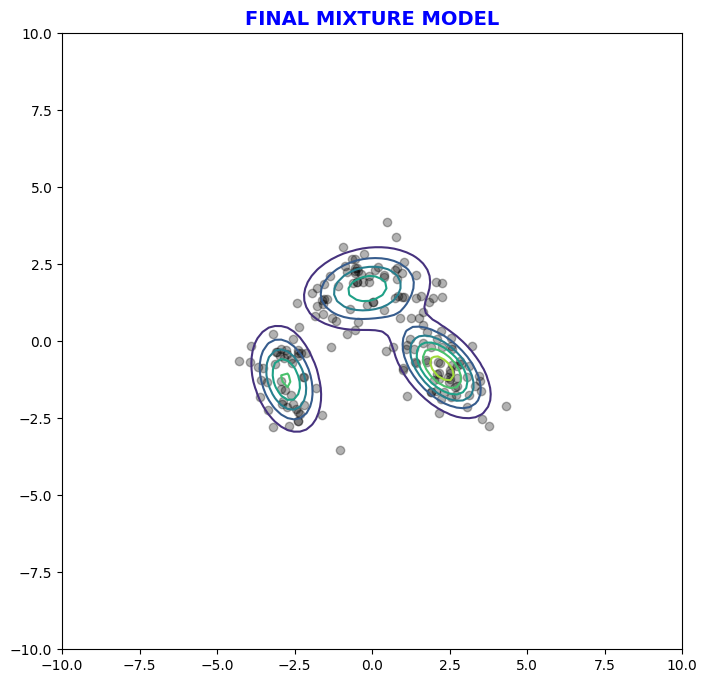

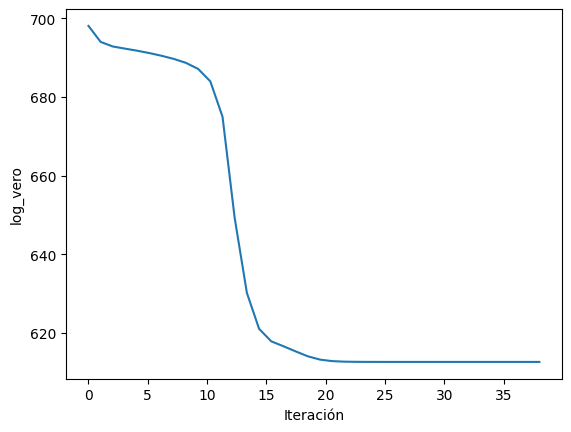

In [ ]:
nll = em_loop(vinos,100,3)
print_nll(nll)

>**Preguntas punto 2:**
* *2.1.* ¿Cómo afecta la inicialización de los parámetros a las mezclas obtenidas?
* *2.2.* Compare los grupos obtenidos con el MMG y las etiquetas o clases previamente establecidas en la base de datos ¿qué puede concluir de esta comparación?

**Respuestas punto 2:**

*2.1.*
Durante el análisis, se observó que las inicializaciones aleatorias pueden tener un impacto significativo en el número de iteraciones requeridas por el algoritmo EM.

Cuando la inicialización se encuentra más cercana a los conjuntos de datos clasificados, el modelo tiende a converger de manera más rápida.
Por otro lado, si la inicialización se encuentra alejada de los conjuntos de datos clasificados, el modelo necesitará un mayor número de iteraciones para converger a una solución adecuada.

*2.2.*
Los grupos obtenidos a través del Modelo de Mezcla de Gaussianas (MMG) son notoriamente similares a las clases presentes en la base de datos. El modelo es capaz de detectar de manera efectiva los diferentes grupos o clases cuando se le proporciona el número adecuado de componentes.


---
## Bibliografía
- Pattern Recognition and Machine Learning, Christopher M. Bishop. https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf (libro original gratis).

- Mathematics for Machine Learning, Marc Peter Deisenroth. https://mml-book.github.io/ (libro original gratis).

- Cuaderno (.ipynb) sobre MMG del libro: Mathematics for Machine Learning. https://github.com/mml-book/mml-book.github.io/blob/master/tutorials/tutorial_gmm.solution.ipynb